In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import random

# Visualize decision dynamics

In [5]:
conditions = [{"tta": tta, "d": d}
                  for tta in measures.tta_condition.unique()
                  for d in measures.d_condition.unique()]

print(conditions)

[{'tta': 4.0, 'd': 90.0}, {'tta': 4.0, 'd': 150.0}, {'tta': 4.0, 'd': 120.0}, {'tta': 5.0, 'd': 90.0}, {'tta': 5.0, 'd': 150.0}, {'tta': 5.0, 'd': 120.0}, {'tta': 6.0, 'd': 90.0}, {'tta': 6.0, 'd': 150.0}, {'tta': 6.0, 'd': 120.0}]


In [2]:
measures = pd.read_csv("../data/measures.csv", index_col=["subj_id", "session", "route", "intersection_no"])
data = pd.read_csv("../data/processed_data.csv", index_col=["subj_id", "session", "route", "intersection_no"])

Let's take a look at the time course of an example trial

In [417]:
traj_id = (129, 1, 2, 5)
traj = data.loc[traj_id].reset_index(drop=True)

In [418]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker="o", ls="", color="C0", label="ego")
    marker_bot, = ax.plot([], [], marker="s", ls="", color="C1", label="bot")
    line_ego, = ax.plot([], [], lw=2, ls="-", color="C0")
    line_bot, = ax.plot([], [], lw=2, ls="-", color="C1")

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x.iloc[i], traj_to_plot.ego_y.iloc[i])
        marker_bot.set_data(traj_to_plot.bot_x.iloc[i], traj_to_plot.bot_y.iloc[i])
        line_ego.set_data(traj_to_plot.ego_x.iloc[:i], traj_to_plot.ego_y.iloc[:i])
        line_bot.set_data(traj_to_plot.bot_x.iloc[:i], traj_to_plot.bot_y.iloc[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title("TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm" % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

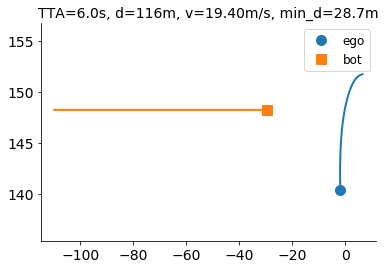

In [419]:
anim = animate_traj(traj)
HTML(anim.to_html5_video())

Let's take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [11]:
def plot_traj(traj, traj_id, fig_path="../output"):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color="C0")
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t, traj.throttle, color="C1")
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color="C2")
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color="C3")
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color="C7", ls="", marker="o", 
                 label="Oncoming car appears")
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color="C7", ls="", marker="x", 
                 label="Decision is made")
    axes[3].set_ylabel("tta")
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel("time $t$")

    legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9), 
                        title="TTA=%.1fs, d=%im" % (tta, d))
    legend.get_title().set_fontsize("18")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, "%s.png" % (str(traj_id))))
    
    return fig, axes

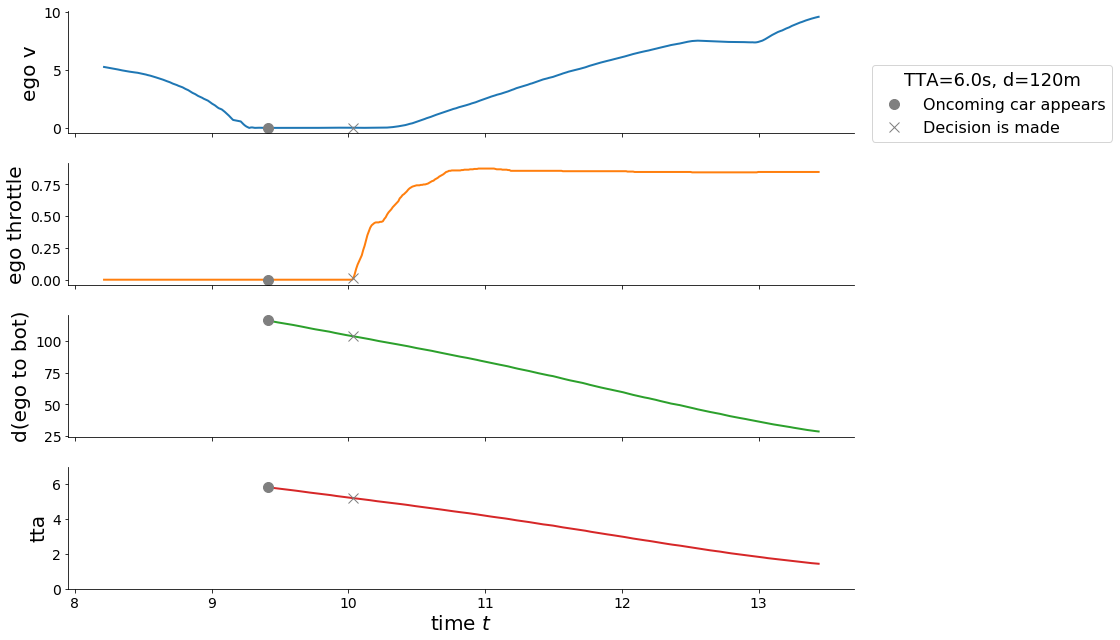

In [422]:
plot_traj(traj, traj_id);

To check whether the algorithms of detecting 1) determining whether a driver decided to turn or to stay, 2) the momement the decision started (bot spawned), and 3) the moment decision was made, we save animations and time series plots for 100 random trials (50 stay's and 50 go's)

In [ ]:
go_traj_ids = random.choices(measures[(measures["decision"]=="Go")].index, k=50)
stay_traj_ids = random.choices(measures[(measures["decision"]=="Stay")].index, k=50)
data_to_animate = data.loc[go_traj_ids + stay_traj_ids]

for traj_id, traj in data_to_animate.groupby(data_to_animate.index.names):
    print(traj_id)
    decision = "Go" if traj.iloc[0].min_distance>5 else "Stay"
    anim = animate_traj(traj.reset_index(drop=True))
    anim.save("../output/%s/%s.mp4" % (decision, str(traj_id)), dpi=150)
    plot_traj(traj.reset_index(drop=True), traj_id, "../output/%s" % (decision))
    plt.close()

Visual inspection of all trials confirmed that the chosen algorithms accurately detect turn/stay decisions and response times in go decisions. 

Response times detected this way in stay decisions are not meaningful. For instance, they can be very short in trials where a subject pressed the throttle while the car was coming but still decided to stay. These RTs are typically short (<1s) and can indicate 1) "rolling" behaviors - the subject crawls towards the middle of the intersection while the car is coming, or 2) a change-of-mind - the subject first decides to go and presses the throttle but then changes the decision to stay. There is no way in which we can distinguish between these possibilities in this version of the task so the resulting RT doesn't tell us much, unfortunately.

Overall share of decisions

In [3]:
print(len(measures))
print(len(measures[(measures["decision"]=="Go")])/len(measures))
print(len(measures[(measures["decision"]=="Stay")])/len(measures))

1879
0.4699308142629058
0.5300691857370942


# Saving birds-eye view of all trajectories

In [ ]:
for traj_id in measures[~(measures.is_go_decision)].index:
    print(traj_id)
    traj = data.loc[traj_id].reset_index()
    plt.figure()
    idx_bot_spawn = int(traj.idx_bot_spawn.iloc[0])
    plt.plot(traj.ego_x[idx_bot_spawn:], traj.ego_y[idx_bot_spawn:])
    plt.plot(traj.bot_x[idx_bot_spawn:], traj.bot_y[idx_bot_spawn:])
    plt.savefig(os.path.join("../output/Stay", "%s.png" % (str(traj_id))))

# Determining decision outcome & detecting collisions

We use the minimum distance between the ego vehicle and the bot to determine whether the participant decided to stay or go. The intuition is that if the participant decides to stay, the minumum distance will be observed at the moment the bot passes the ego vehicle in the opposite lane, and will be close to the lane width (3.5 meters). At the same time, if the minimum distance is much larger than the lane width, that necessarily means that the participant has left the intersection when the bot arrived there.

Based on the histogram of the minimum distances in trials where it was <10m, we determined the threshold of 5 meters which clearly separates the two modes of the distribution. 

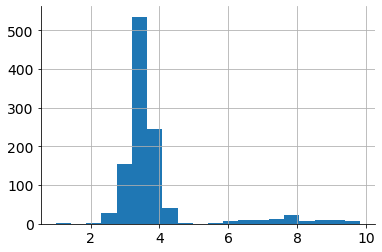

In [424]:
measures[measures.min_distance<10].min_distance.hist(bins=20)

Visual inspection of all trajectories confirmed that this heuristic works in vast majority of the cases, except a few in which there were collisions.

We found 13 collisions in total, all of them happened in trials where the participants decided to go. Eight of them happened because the participants started turning but then hit the stop sign and got stuck in the lane of the oncoming car, which eventually collided with the ego vehicle. Five others were heads-on collisions or collisions where the oncoming car hit the tail of the ego vehicle. 

The collisions are interfering with our heuristic of determining the outcome of the decision (if the minimum distance between the centers of the cars is less than 5 meters, the trial is classified as "stay"). For this reason, in data preprocessing we marked all trials with collisions as "go".

In [ ]:
collision_traj_ids = [(129, 1, 1, 5), (280, 1, 2, 16), (421, 1, 1, 5), (421, 1, 1, 20), (421, 1, 2, 3), 
                      (421, 1, 2, 21), (421, 2, 8, 8), (525, 1, 2, 7), (755, 1, 1, 8), (853, 1, 1, 13), 
                     (853, 1, 3, 9), (853, 1, 4, 10), (853, 2, 6, 13)]
data_to_animate = data.loc[collision_traj_ids]

for traj_id, traj in data_to_animate.groupby(data_to_animate.index.names):
    anim = animate_traj(traj.reset_index(drop=True))
    anim.save("../output/Collisions/%s.mp4" % (str(traj_id)), dpi=150)
    plt.close()

## Checking excluded data

Types of excluded trials
- the bot did not spawn at all e.g. (642, 2, 7, 3). In this case the participant did not make any decision at all
- the bot did spawn but at the time of bot spawn, the participant had the throttle pressed and kept it pressed after that e.g. (129, 1, 1, 1) and (755, 2, 6, 14) and (642, 1, 2, 14). In this case the participant made the "go" decision but it's impossible to infer the response time so we exclude those trials.

In total, there are 36 excluded trials, of which most are the no-bot trials

In [361]:
measures_excluded = pd.read_csv("../data/measures_excluded.csv", 
                            index_col=["subj_id", "session", "route", "intersection_no"])
data_excluded = pd.read_csv("../data/processed_data_excluded.csv", 
                        index_col=["subj_id", "session", "route", "intersection_no"])

(827, 2, 7, 12)


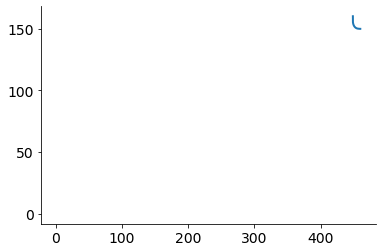

In [432]:
traj_id = random.choice(measures_excluded.index)
# traj_id = (421, 2, 5, 25)
print(traj_id)
traj = data_excluded.loc[traj_id].reset_index()
plt.plot(traj.ego_x, traj.ego_y)
plt.plot(traj.bot_x, traj.bot_y)

## Checking individual trials

In [30]:
excluded_measures = (measures.RT < 0.1) | ((measures.RT > 2) & measures.is_go_decision)
measures[excluded_measures]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     11                        91.0          92.0   
                4     25                         0.0         238.0   
389     2       8     2                         81.0          82.0   
525     1       1     22                        67.0          75.0   
        2       8     16                        17.0          21.0   
642     1       1     20                       118.0         127.0   
                4     24                        19.0          26.0   
652     1       3     9                         65.0          66.0   
755     1       1     1                         30.0          35.0   
                      22                        23.0          29.0   
827     1       2     10                        92.0          98.0   
969     1       3     24                        66.0          73.0   
                4     22                        55.0          64.0   
996     1       3     6                         40.0          49.0   

                                       idx_min_distance  min_distance      RT  \
subj_id session route intersection_no                                           
129     1       1     11                          380.0     48.915927  0.0104   
                4     25                            7.0     47.822718  2.4927   
389     2       8     2                           541.0      4.262740  0.0103   
525     1       1     22                          370.0     61.226892  0.0824   
        2       8     16                          572.0      3.658391  0.0413   
642     1       1     20                          448.0     38.732485  0.0924   
                4     24                          488.0      3.693436  0.0719   
652     1       3     9                           427.0      2.483714  0.0108   
755     1       1     1                            37.0      4.330622  0.0934   
                      22                          376.0     26.291364  0.0618   
827     1       2     10                          488.0     17.492785  0.0630   
969     1       3     24                          431.0      3.633479  0.0733   
                4     22                          341.0     22.845095  0.0980   
996     1       3     6                           333.0     42.836817  0.0958   

                                       is_go_decision  is_collision decision  \
subj_id session route intersection_no                                          
129     1       1     11                         True         False       Go   
                4     25                         True         False       Go   
389     2       8     2                         False         False     Stay   
525     1       1     22                         True         False       Go   
        2       8     16                        False         False     Stay   
642     1       1     20                         True         False       Go   
                4     24                        False         False     Stay   
652     1       3     9                         False         False     Stay   
755     1       1     1                         False         False     Stay   
                      22                         True         False       Go   
827     1       2     10                         True         False       Go   
969     1       3     24                        False         False     Stay   
                4     22                         True         False       Go   
996     1       3     6                          True         False       Go   

                                       tta_condition  d_condition  v_condition  
subj_id session route intersection_no                                           
129     1       1     11                         6.0        120.0         20.0  
                4     25                         4.0        120.0         30.0  
389     2       

In [52]:
# measures[measures.is_go_decision & (measures.RT>1.5)].loc[129]
measures[~((measures.RT > 0) & ((measures.RT < 2.0) | ~(measures.is_go_decision)))]

,,,,idx_bot_spawn,idx_response,idx_min_distance,min_distance,RT,is_go_decision,is_collision,decision,tta_condition,d_condition,v_condition
subj_id,session,route,intersection_no,,,,,,,,,,,
129,1,4,25,0.0,238.0,7.0,47.822718,2.4927,True,False,Go,4.0,120.0,30.0


(<Figure size 864x648 with 4 Axes>,
 array([<AxesSubplot:ylabel='ego v'>, <AxesSubplot:ylabel='ego throttle'>,
        <AxesSubplot:ylabel='d(ego to bot)'>,
        <AxesSubplot:xlabel='time $t$', ylabel='tta'>], dtype=object))

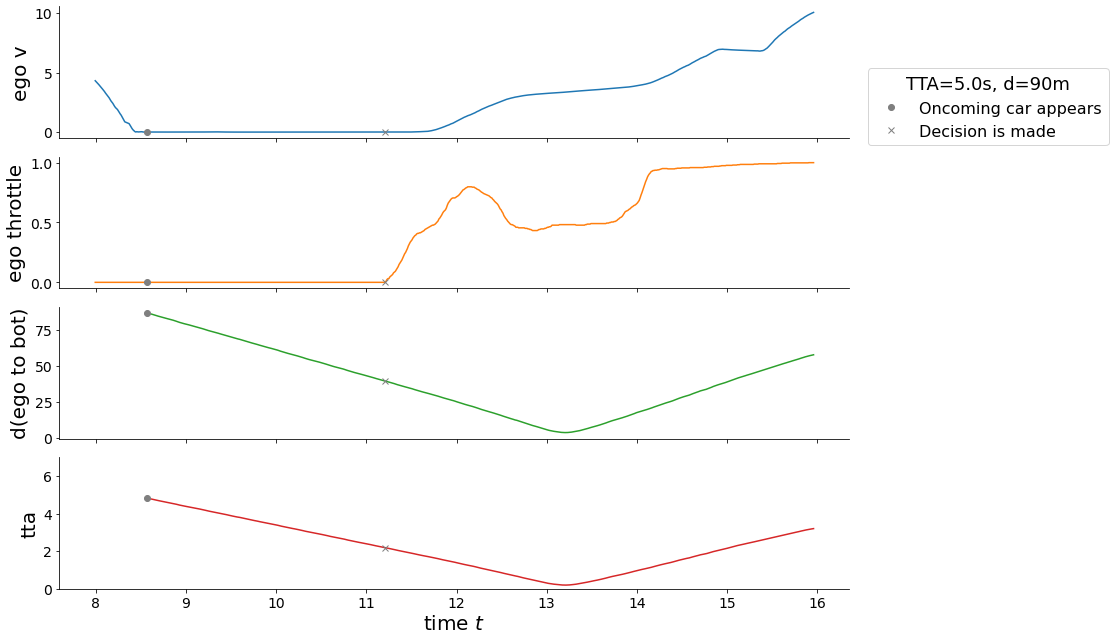

In [46]:
# 2.5s RT - bug - the oncoming car was not moving
# traj_id = (129, 1, 4, 25)
# 2s RT - bug - the oncoming car was not moving
traj_id = (129, 1, 2, 19)
# 0.01 RT - artifact?
# traj_id = (129, 1, 1, 11)
# 0.1 RT - plausible
# traj_id = (969, 1, 4, 22)
traj = data.loc[traj_id].reset_index()
# plt.plot(traj.t[100:], traj.d_ego_bot[100:])
plot_traj(traj, traj_id)
# anim = animate_traj(traj)
# HTML(anim.to_html5_video())

# Effect of TTA on decision and RT

In [8]:
measures_go = measures[measures.is_go_decision]

Probability of go increases with time gap

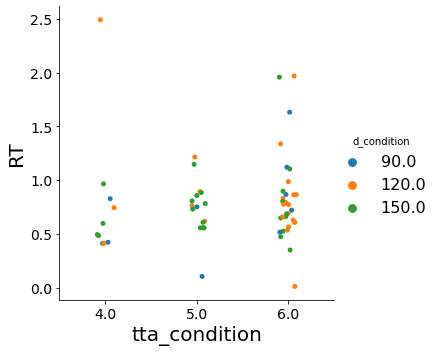

In [48]:
sns.catplot(kind="strip", data=measures[measures.is_go_decision].loc[129], x="tta_condition", y="RT", hue="d_condition")

In [436]:
def plot_dv_vs_iv_by_subj(measures, dv, iv):
    g = sns.catplot(kind="point", data=measures, x=iv, y=dv, hue="subj_id", join=True, dodge=0.2)
    ax = g.axes[0][0]
    sns.despine(trim=True, offset=5)
    plt.setp(ax.collections, alpha=.7)
    plt.setp(ax.lines, alpha=.7)    
    plt.setp(ax.collections, zorder=1)
    plt.setp(ax.lines, zorder=1)
    sns.pointplot(ax=ax, data=measures, x=iv, y=dv, marker="o", color="k", zorder=10)    
    plt.setp(ax.collections[-1], zorder=10)
    return ax

def plot_RT_vs_var(measures, var, hue, violin=False):
    if violin:
        g = sns.catplot(data=measures, x=var, y="RT", kind="violin", color="grey", inner=None)
        ax = g.axes[0][0]
    else:
        fig, ax = plt.subplots()
    sns.pointplot(ax=ax, data=measures, x=var, y="RT", hue=hue, dodge=0.2)
    plt.setp(ax.lines, alpha=.5)
    plt.setp(ax.collections, alpha=.5)
    sns.pointplot(ax=ax, data=measures, x=var, y="RT", color="k")
    plt.setp(ax.collections[-1], zorder=10)
    sns.despine(trim=True, offset=5)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(hue, prop={"size":18})
    return ax

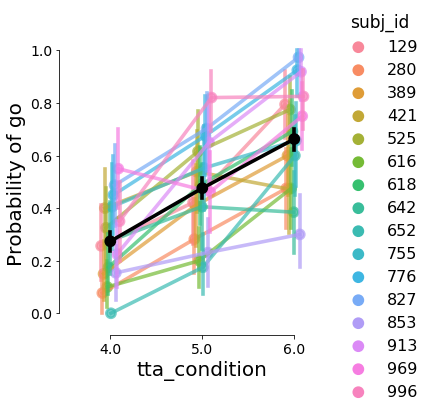

In [441]:
ax = plot_dv_vs_iv_by_subj(measures.reset_index(), dv="is_go_decision", iv="tta_condition")
ax.set_ylabel("Probability of go");

Zooming in on go decisions, we look at RTs as a function of TTA condition

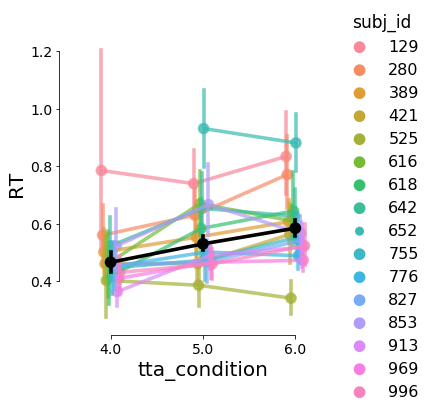

In [444]:
plot_dv_vs_iv_by_subj(measures_go.reset_index(), iv="tta_condition", dv="RT")

We found a positive relationship between TTA condition and RT, which isn't what would be predicted by the constant-drift-rate DDM. The latter implies that for low-probability decisions we have longest response times, while we see the opposite picture. Modeling help to clarify the reason for this

# Effect of distance on decision and RT

As expected, probability of turning also increases with distance

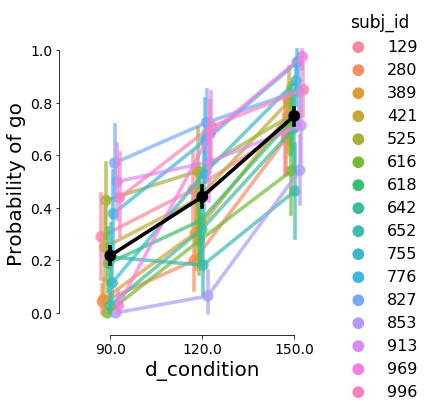

In [445]:
ax = plot_dv_vs_iv_by_subj(measures.reset_index(), iv="d_condition", dv="is_go_decision")
ax.set_ylabel("Probability of go");

Interestingly though, RT doesn't seem to change much with distance in general. Statistical analyses will help to clarify if there is a significant (albeit small) effect of distance on RT

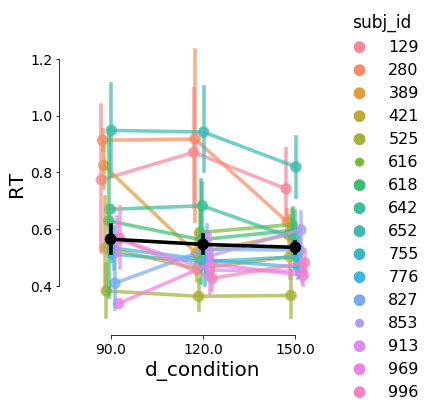

In [446]:
plot_dv_vs_iv_by_subj(measures_go.reset_index(), iv="d_condition", dv="RT");

# Aggregate data for all subjects

Let"s aggregate the data for all subjects, given that the patterns seem to be fairly consistent across the sample so far.

This is just to illustrate that probability of turning increases with both distance and TTA.

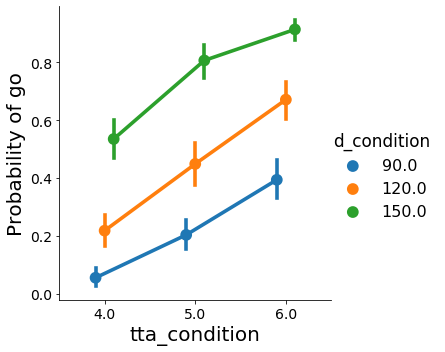

In [448]:
g = sns.catplot(kind="point", data=measures, x="tta_condition", y="is_go_decision", hue="d_condition", 
                join=True, dodge=0.2)
g.axes[0][0].set_ylabel("Probability of go");

Aggregated data also shows that RT increases with TTA

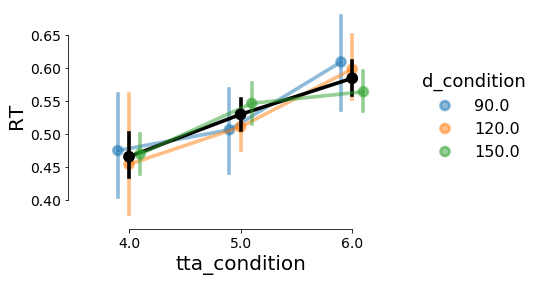

In [449]:
plot_RT_vs_var(measures_go, var="tta_condition", hue="d_condition");

At the same time, RT might seem to decrease with distance, although the effect (if any) is tiny

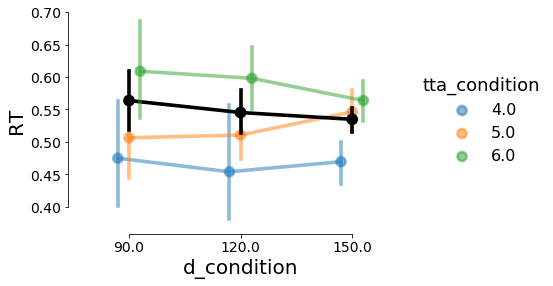

In [450]:
plot_RT_vs_var(measures_go, var="d_condition", hue="tta_condition");

# Response time distributions

Let"s look into the RT distributions to see if there are the long tails there (we"d expect to see them for instance in the "vanilla" DDM)

In [453]:
def plot_RT_kde(measures_turn, var, logscale=False):
    for value, group in measures_turn.groupby(var):
        ax = sns.kdeplot(group.RT, label=value, shade=True)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(var, prop={"size":18})
    ax.set_xlabel("RT")
    ax.set_ylabel("probability")
    if logscale:
        ax.set_ylim((0.0001, 10))
        ax.set_yscale("log")
    return ax

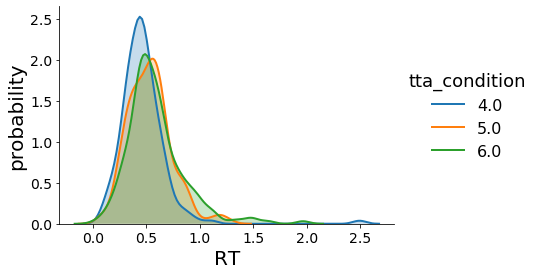

In [454]:
plot_RT_kde(measures_go, var="tta_condition", logscale=False)

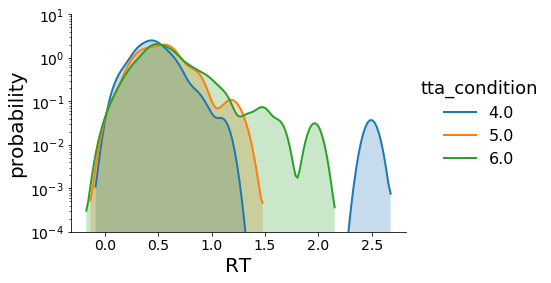

In [455]:
plot_RT_kde(measures_go, var="tta_condition", logscale=True)

We don't have enough of data per participant to reconstruct individual participants' distributions, unfortunately. At most, we have around 30 RTs per participant per condition which still leads to very noisy KDE estimates 

In [462]:
measures_go.reset_index().groupby(["subj_id", "tta_condition"]).size()

subj_id  tta_condition
129      4.0              10
         5.0              16
         6.0              31
280      4.0               3
         5.0              11
         6.0              19
389      4.0               6
         5.0              16
         6.0              24
421      4.0              16
         5.0              21
         6.0              17
525      4.0              13
         5.0              24
         6.0              31
616      4.0               4
         5.0               8
         6.0              19
618      4.0               7
         5.0              20
         6.0              27
642      4.0              11
         5.0              15
         6.0              15
652      5.0               7
         6.0              24
755      4.0              15
         5.0              21
         6.0              23
776      4.0              18
         5.0              27
         6.0              37
827      4.0              19
         5.0        

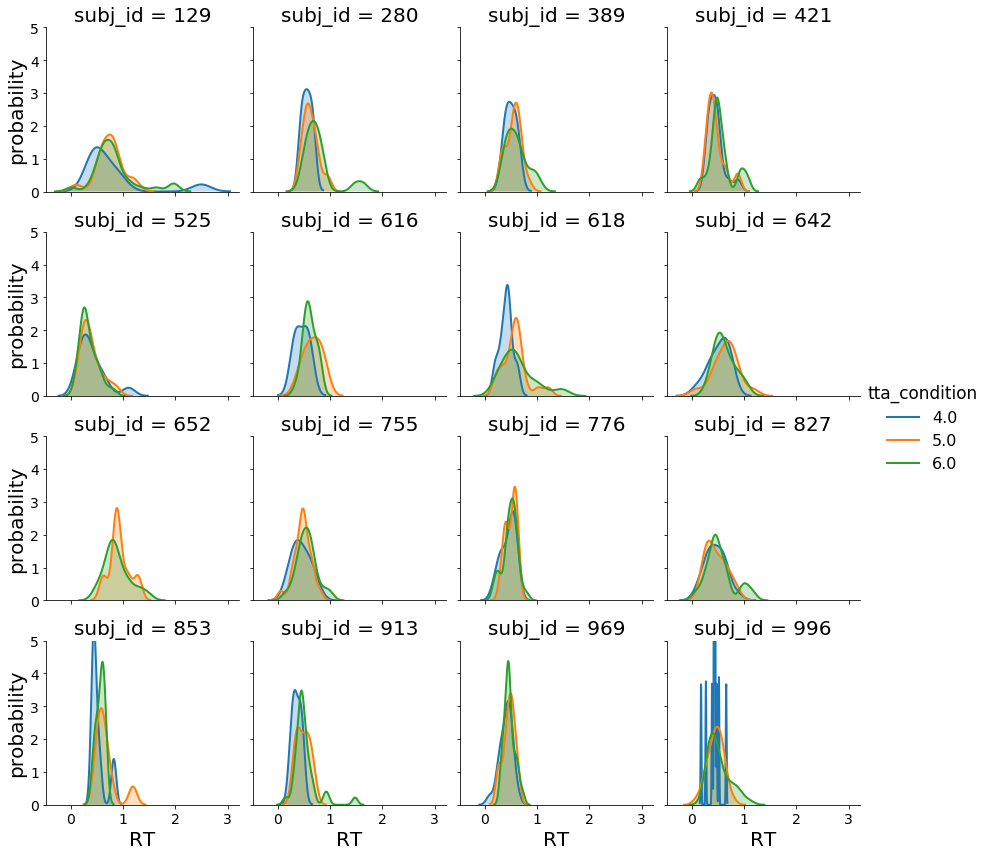

In [465]:
g = sns.FacetGrid(measures_go.reset_index(), col="subj_id", hue="tta_condition", col_wrap=4)
g.map(sns.kdeplot, "RT", shade=True).add_legend().set_axis_labels("RT", "probability")
g.set(ylim=(0, 5))